# **Face Recognition System Using Keras FaceNet**

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lfwpeople/pairsDevTrain.txt
/kaggle/input/lfwpeople/lfw-funneled.tgz
/kaggle/input/lfwpeople/pairsDevTest.txt
/kaggle/input/lfwpeople/pairs.txt


In [ ]:
!tar -xvzf /kaggle/input/lfwpeople/lfw-funneled.tgz -C /kaggle/working/

lfw_funneled/
lfw_funneled/George_HW_Bush/
lfw_funneled/George_HW_Bush/George_HW_Bush_0001.jpg
lfw_funneled/George_HW_Bush/George_HW_Bush_0002.jpg
lfw_funneled/George_HW_Bush/George_HW_Bush_0003.jpg
lfw_funneled/George_HW_Bush/George_HW_Bush_0004.jpg
lfw_funneled/George_HW_Bush/George_HW_Bush_0005.jpg
lfw_funneled/George_HW_Bush/George_HW_Bush_0006.jpg
lfw_funneled/George_HW_Bush/George_HW_Bush_0007.jpg
lfw_funneled/George_HW_Bush/George_HW_Bush_0008.jpg
lfw_funneled/George_HW_Bush/George_HW_Bush_0009.jpg
lfw_funneled/George_HW_Bush/George_HW_Bush_0010.jpg
lfw_funneled/George_HW_Bush/George_HW_Bush_0011.jpg
lfw_funneled/George_HW_Bush/George_HW_Bush_0012.jpg
lfw_funneled/George_HW_Bush/George_HW_Bush_0013.jpg
lfw_funneled/Curtis_Strange/
lfw_funneled/Curtis_Strange/Curtis_Strange_0001.jpg
lfw_funneled/Marc_Grossman/
lfw_funneled/Marc_Grossman/Marc_Grossman_0001.jpg
lfw_funneled/Marc_Grossman/Marc_Grossman_0002.jpg
lfw_funneled/Marc_Grossman/Marc_Grossman_0003.jpg
lfw_funneled/Marc_Gros

In [ ]:
%cd /kaggle/working/lfw_funneled

/kaggle/working/lfw_funneled


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, ZeroPadding2D, Activation, Input, BatchNormalization,
    MaxPooling2D, AveragePooling2D, Concatenate, Lambda, Flatten, Dense
)
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras import backend as K
import numpy as np
import pandas as pd
from numpy import genfromtxt
import PIL.Image as Image
import os

K.set_image_data_format('channels_last')

%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
pip install keras-facenet

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from keras_facenet import FaceNet
keras_model=FaceNet()
model=keras_model.model

I0000 00:00:1748927627.200615      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [ ]:
print(model.inputs)
print(model.outputs)

[<KerasTensor shape=(None, None, None, 3), dtype=float32, sparse=False, name=keras_tensor>]
[<KerasTensor shape=(None, 512), dtype=float32, sparse=False, name=keras_tensor_449>]


In [ ]:
FRmodel=model

In [ ]:
tf.keras.backend.set_image_data_format('channels_last')
def img_to_encoding(image_path, model):
  img=tf.keras.preprocessing.image.load_img(image_path, target_size=(160, 160))
  img=np.around(np.array(img)/255.0, decimals=12)
  x_train=np.expand_dims(img, axis=0)
  embedding=model.predict_on_batch(x_train)
  return embedding/np.linalg.norm(embedding, ord=2)

In [ ]:
import os
import numpy as np

def build_face_database(main_folder_path, model):
    database = {}

    for person_name in os.listdir(main_folder_path):
        person_folder = os.path.join(main_folder_path, person_name)

        if os.path.isdir(person_folder):
            # Normalize name format: lowercase and remove underscores
            clean_name = person_name.strip().replace("_", " ").lower()
            embeddings = []

            for img_name in os.listdir(person_folder):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(person_folder, img_name)
                    emb = img_to_encoding(img_path, model)
                    embeddings.append(emb)

            if embeddings:
                avg_embedding = np.mean(embeddings, axis=0)
                database[clean_name] = avg_embedding

    return database


In [ ]:
database=build_face_database("/kaggle/working/lfw_funneled", FRmodel)

I0000 00:00:1748927635.147562     116 service.cc:148] XLA service 0x7e53240703a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748927635.148444     116 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748927636.393895     116 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1748927639.226575     116 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [ ]:
def who_is_it(image_path, database, model):
  """
  Implements face recognition for the office by finding who is the person on "image_path" image

  Arguments:
    image_path -- path to an image
    database -- database ccontaing the encodings along with name of the person on the image
    model -- our Inception model instance in Keras

  Returns:
    min_dist -- the minimum distance between image path encoding and the encoding from the database
    identity -- string, the name prediction for the person on image_path
  """

  ## Step-1: Compute the target "encoding" for the image. We'll use img_to_encoding()
  encoding=img_to_encoding(image_path, model)

  ## Step-2 Find the closest encoding

  # Initialize min_dist to a large value, say 100
  min_dist=100

  # Loop over databse dictionary's names and encodings
  for (name, db_enc) in database.items():
    # Compute L2 distance between target "encoding" and current db_enc from the database.
    dist=np.linalg.norm(encoding-db_enc)

    # If this distance is less than min_dist, then set min_dist to dist, and identify the name.
    if dist<min_dist:
      min_dist=dist
      identity=name

  print("It's "+str(identity)+", the distance is " + str(min_dist))




  return min_dist, identity

In [ ]:
import cv2
import numpy as np

# Haar cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

def annotate_faces_with_boxes_and_labels(image_path, model, database):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not load image: {image_path}")

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        # Extract face region and save temporarily
        face_img = img[y:y+h, x:x+w]
        temp_path = "/tmp/temp_face.jpg"
        cv2.imwrite(temp_path, face_img)

        # Get identity using your model
        identity = who_is_it(temp_path, database, model)[1]

        # Draw bounding box
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Text settings
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.7
        thickness = 2
        label = str(identity)

        # Put the text label above the box
        (text_width, text_height), baseline = cv2.getTextSize(label, font, font_scale, thickness)
        text_y = y - 10 if y - 10 > text_height else y + h + text_height + 10
        cv2.putText(img, label, (x, text_y), font, font_scale, (0, 255, 0), thickness)

    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
def show_img(image_path):

  output = annotate_faces_with_boxes_and_labels(image_path, FRmodel, database)

  plt.imshow(output)
  plt.axis("off")
  plt.title("Recognized Face(s)")
  plt.show()

It's aj cook, the distance is 0.5866281


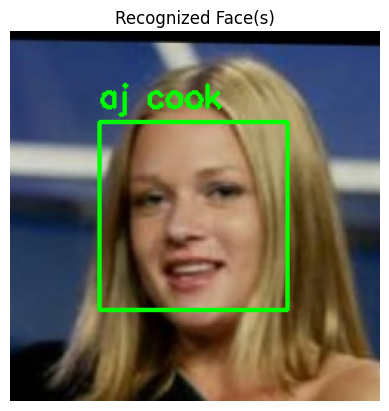

In [ ]:
show_img("/kaggle/working/lfw_funneled/AJ_Cook/AJ_Cook_0001.jpg")

It's angelina jolie, the distance is 0.63563913


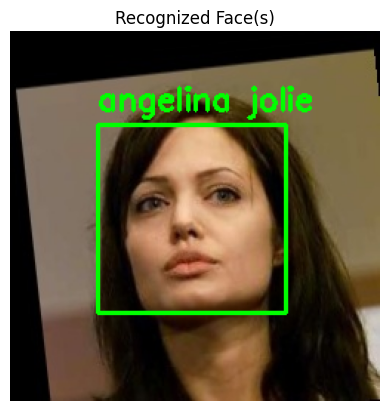

In [ ]:
show_img("/kaggle/working/lfw_funneled/Angelina_Jolie/Angelina_Jolie_0007.jpg")

It's bill gates, the distance is 0.80351305


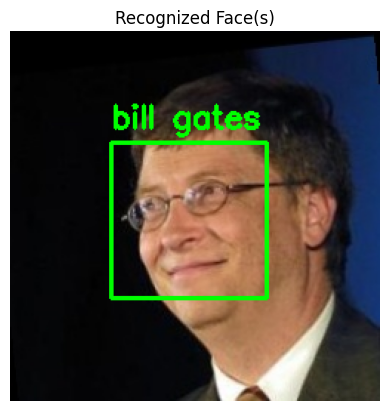

In [ ]:
show_img("/kaggle/working/lfw_funneled/Bill_Gates/Bill_Gates_0002.jpg")

Our Face Recognition System works well ith the dataset.

***Feel free to upload any celeb image, and see the exciting results!***